In [1]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation

import optitrack.csv_reader as csv
from optitrack.geometry import *

filename = "../material/60fps/ProvaRigidBody.csv"

### READ CSV AND LOAD DATA

In [2]:
# Read the file.
take = csv.Take().readCSV(filename)


# Print out some statistics
print("Found rigid bodies:", take.rigid_bodies.keys())

# Process the first rigid body into a set of planes.
bodies = take.rigid_bodies
  



bones_pos = []
rigid_body_markers_pos = []
markers_pos = []
if len(bodies) > 0:
    for body in bodies: 
        bones = take.rigid_bodies[body]
        n_frames = bones.num_total_frames()
        bones_pos.append(bones.positions)
        for marker in bones.rigid_body_markers.values():
            rigid_body_markers_pos.append(marker.positions)
        for marker in bones.rigid_body_markers.values():
            markers_pos.append(marker.positions)

# substitute with [0,0,0] 'None' values
# matrix = [[0,0,0] if elem is None else elem for elem in bones_pos[0]]
points = bones_pos + rigid_body_markers_pos + markers_pos

#points = [[0.0,0.0,0.0] if elem is None else elem for elem in markers for markers in points ]
points = [[[0.0, 0.0, 0.0] if frame is None else frame for frame in markers] for markers in points]

np_points = np.array(points)


Found rigid bodies: dict_keys(['Ragnetto'])


In [3]:
x = np_points[:,:,0]
y = np_points[:,:,1]
z = np_points[:,:,2]



### DISPLACE ANIMATION

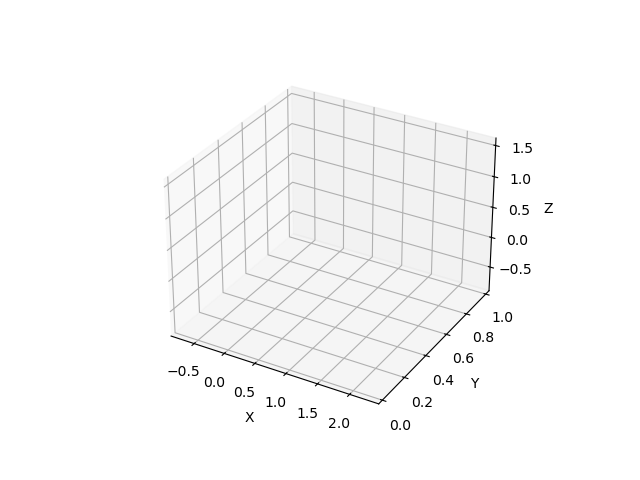

In [4]:

# Plot properties
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel('Z')

ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))


txt = fig.suptitle('')

# initialize empty set of points
points, = ax.plot([], [], [], "o")

# define an animation function
# this determines the plot's behavior at each frame
def update(t):
    txt.set_text('frame={:d}'.format(t))
    # print(len(x[:,t]))
    # update properties
    updated_positions = np.array((x[:,t],y[:,t],z[:,t]), dtype=float)
    
    points.set_data_3d(updated_positions)

    # return modified artists
    return points, txt

ani=animation.FuncAnimation(fig, update, frames=n_frames) 
#ani.save(filename="animations/animation.gif", writer="pillow", fps=60)

plt.show()